Files in bottle_flipping : ['2023-05-21-diff-bottle-flip-ours', 'diff-bottle-model-cma-2023-05-21--09-53-36-[0]', 'diff-bottle-model-oneplusone-2023-05-21--09-53-36-[1]']

Files in high_diving : ['2023-05-14-high-diving-duck-ours', 'diff-high-diving-duck-cma-2023-05-19--13-03-52-[0]', 'diff-high-diving-duck-oneplusone-2023-05-18--16-03-41-[0]']

Files in stone_skipping : ['2023-05-19-stone-skipping-ours', 'diff-stone-skipping-cma-2023-05-19--12-50-12-[0]', 'diff-stone-skipping-oneplusone-2023-05-19--13-10-56-[0]']

Files in water_rafting : ['2023-05-14-dambreak-bunny-only-vy', '2023-05-14-dambreak-bunny-ours', 'diff-dambreak-bunny-cma-2023-05-20--19-48-06-[1]', 'diff-dambreak-bunny-oneplusone-2023-05-20--19-48-06-[0]']



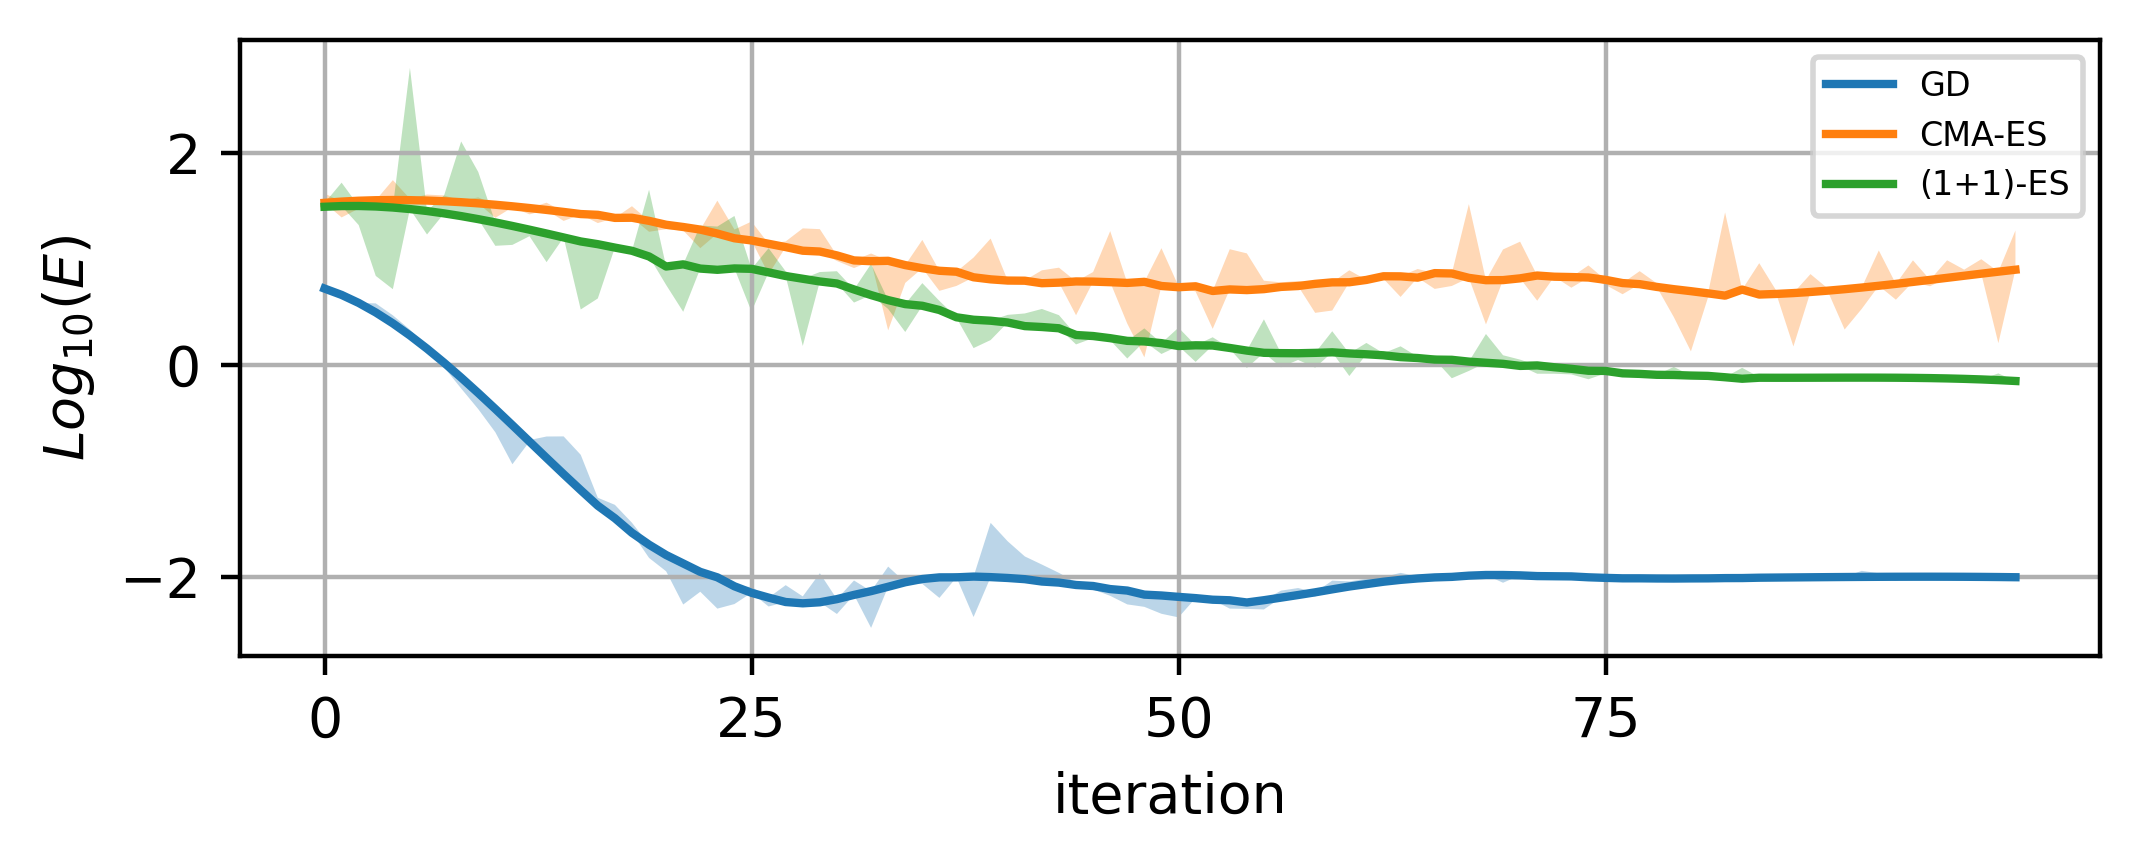

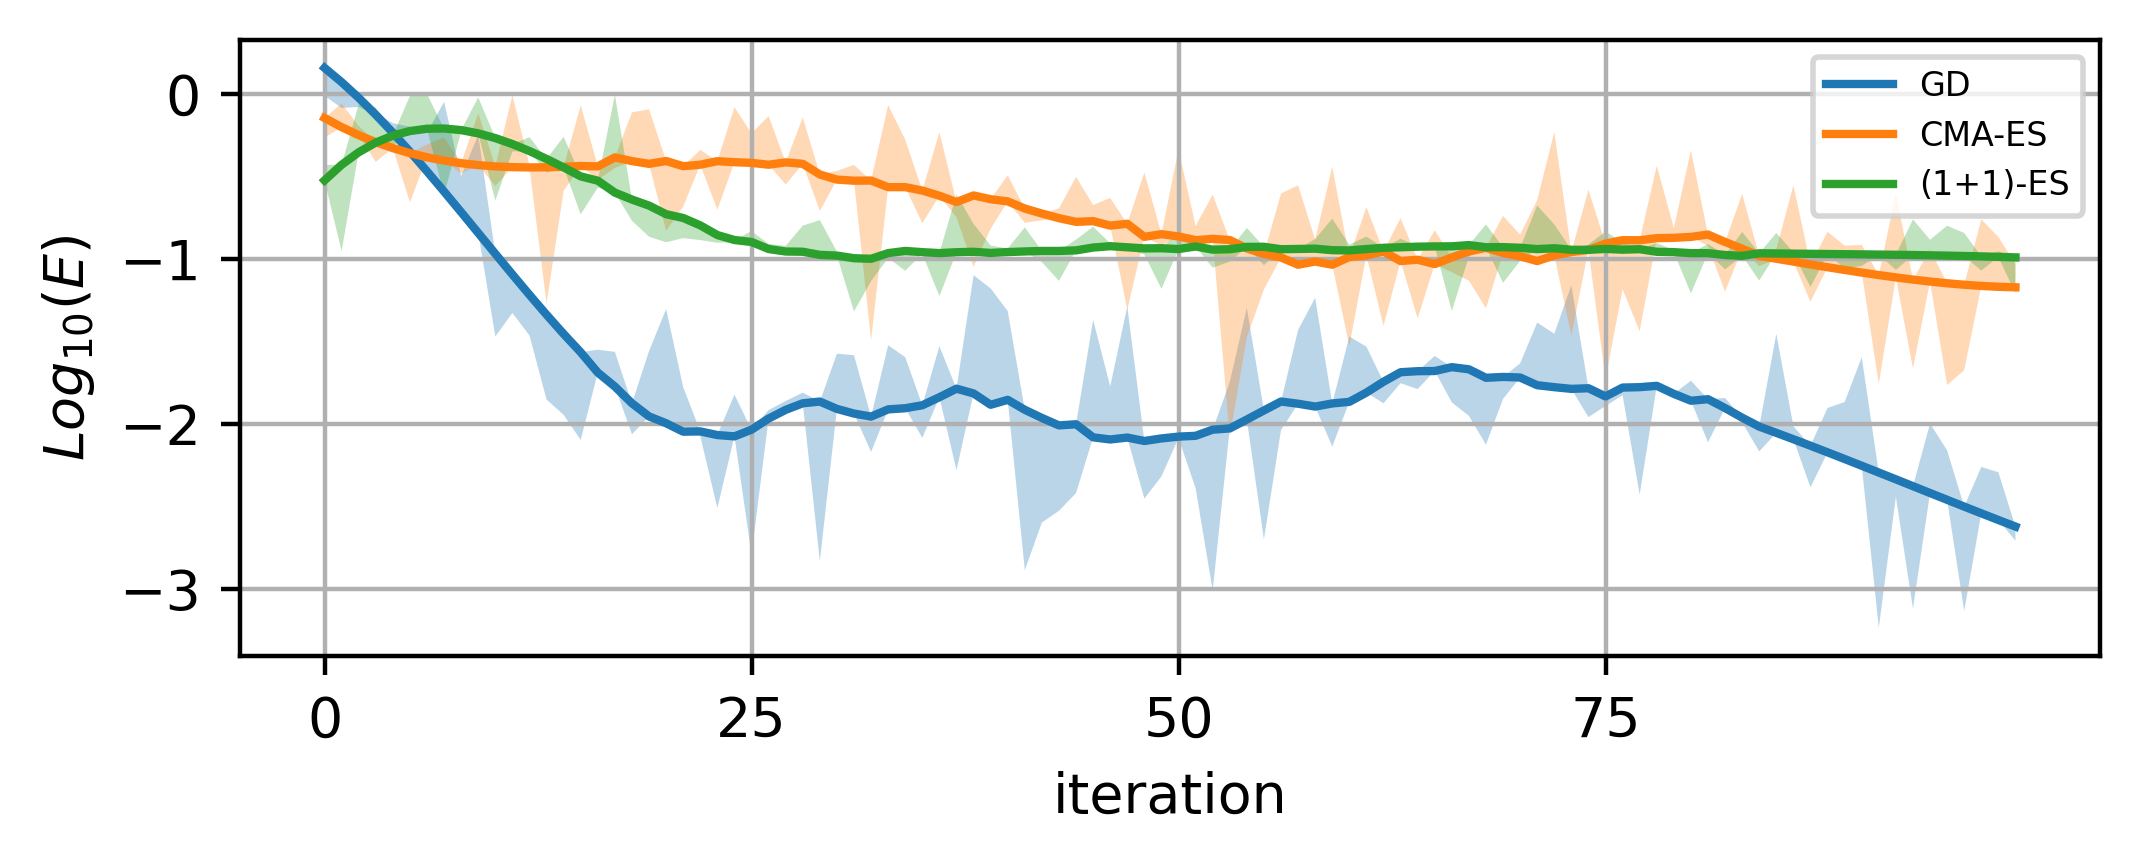

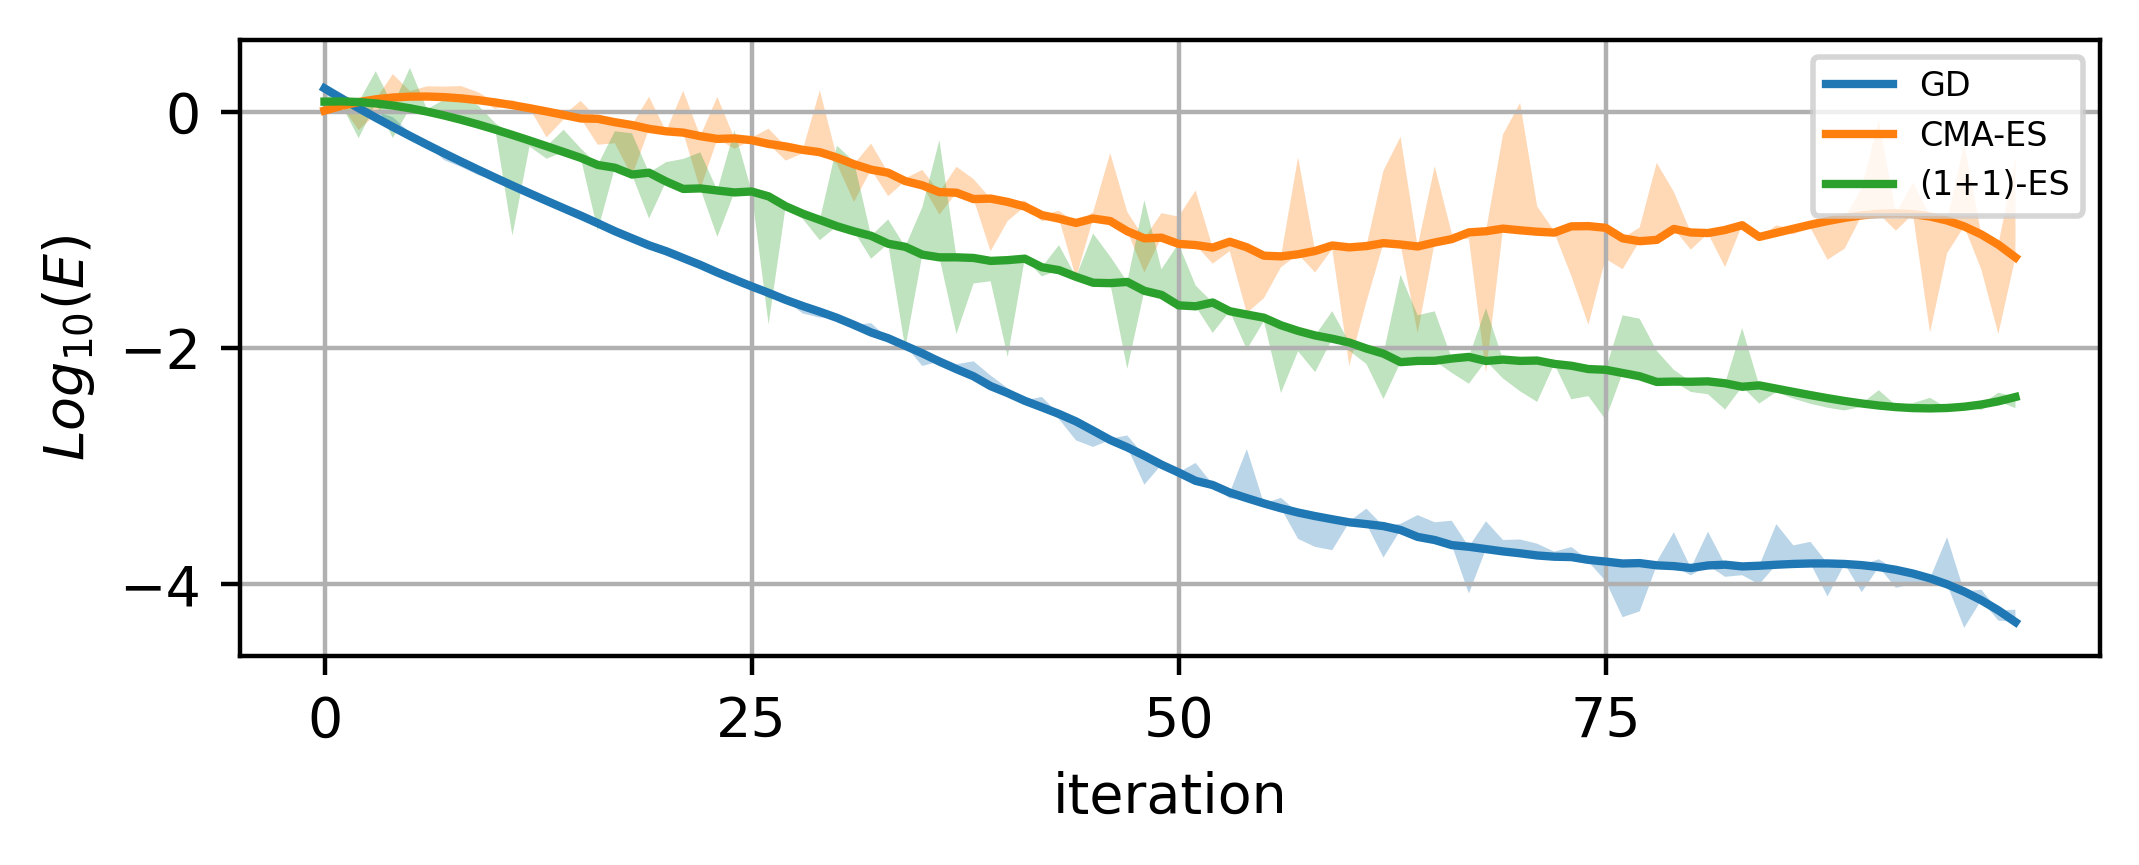

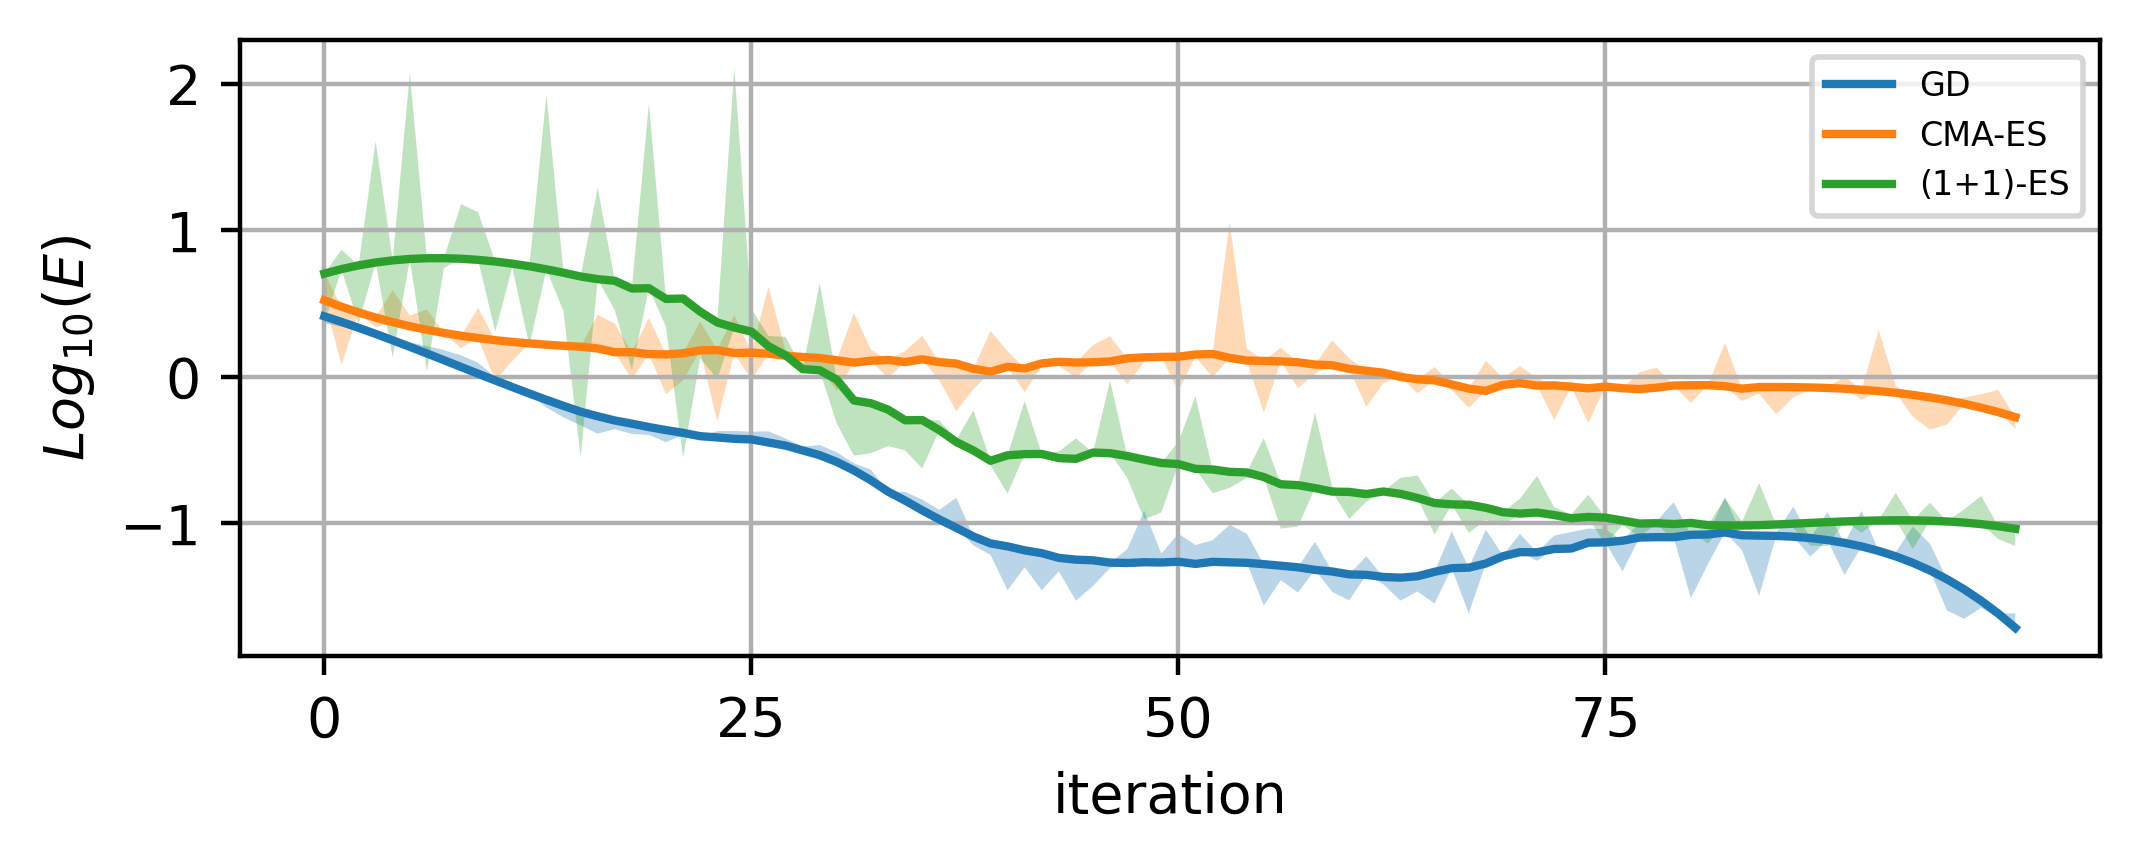

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt 
import numpy as np
from scipy.signal import savgol_filter

path = Path('./')

files_by_grandparent = {}

for file in path.rglob('*.txt'):
    if file.is_file():
        grandparent = file.parents[2]
        if grandparent not in files_by_grandparent:
            files_by_grandparent[grandparent] = []
        files_by_grandparent[grandparent].append(file)

def get_loss_from_log(path):
    loss_x = []
    loss_rotation = []
    loss = []   
    penalty = []   
    with open(path) as f:
        lines = f.readlines()
        for s in lines[1:]:
            s = s.split(sep='=')
            if 'loss_rotation' in s[0] and 'grad' not in s[0] and 'line search' not in s[0]:
                l = float(s[1][:-5])
                loss_rotation.append(l)
            if 'loss_x' in s[0] and 'grad' not in s[0] and 'line search' not in s[0]:
                l = float(s[1][:-5])
                loss_x.append(l)
            if 'loss ' in s[0] and 'grad' not in s[0] and 'line search' not in s[0]:
                l = float(s[1][:-5])
                loss.append(l)
            if 'penalty' in s[0] and 'grad' not in s[0]:
                p = float(s[1][:-5])
                penalty.append(p)
    return loss_x, loss_rotation, loss, penalty


def draw(datas:list, labels, start_idx = 0, ylabel='$Log_{10}(E)$', xlabel="iteration", styles=None):
    end_idx=100
    for i in range(len(datas)):
        data = datas[i][start_idx:end_idx]
        x = list(range(len(data)))
        y = np.log10(np.array(data))
        window_size = 31
        order = 3
        y_smooth = savgol_filter(y, window_size, order)
        if styles is None:
            plt.plot(list(range(len(data))), y, label = labels[i])
            plt.plot(list(range(len(data))), y_smooth, label = labels[i])
        else:
            # plt.plot(list(range(len(data))), y, label = labels[i], color=styles[0])
            plt.plot(list(range(len(data))), y_smooth, label = labels[i])
            # Ref: https://matplotlib.org/stable/gallery/lines_bars_and_markers/fill_between_demo.html#example-confidence-bands
            plt.fill_between(list(range(len(data))), np.minimum(y, y_smooth), np.maximum(y, y_smooth), alpha=0.3)
        plt.legend(fontsize = 6,loc='upper right')
        plt.xlabel(xlabel)
        plt.grid(True)
        plt.xticks(np.arange(0, end_idx, 25))
        plt.ylabel(ylabel)

blue = (31 / 255, 119 / 255, 180 / 255, 1)
light_blue = (31 / 255, 119 / 255, 180 / 255, 0.5)

orange = (255 / 255, 127 / 255, 14 / 255, 1)
light_orange = (255 / 255, 127 / 255, 14 / 255, 0.5)

green = (44/255, 160/255, 44/255, 1)
light_green = (44/255, 160/255, 44/255, 0.5)

for grandparent in files_by_grandparent.keys():
    files = files_by_grandparent[grandparent]
    files.sort()
    plt.figure(figsize=(6,2), dpi=400)
    # plt.title(grandparent.name)
    end = 100
    print(f"Files in {grandparent.name} : {[f.parent.parent.name for f in files]}\n")
    for log in files: 
        loss_x, loss_rotation, loss, penalty = get_loss_from_log(log)
        if 'ours' in log.parent.parent.name:
            if loss[0] == loss[1]:
                loss = loss[::2]
            loss = loss[:end]
            draw([loss], [f'GD'], styles=[light_green, green])
        elif 'cma' in log.parent.parent.name:
            loss = loss[:end]
            draw([loss], ['CMA-ES'], styles=[light_orange, orange ])
        elif 'one' in log.parent.parent.name:
            loss = loss[:end]
            draw([loss], ['(1+1)-ES'],styles=[light_blue, blue ])